# Прогнозирование уровня средней заработной платы в России

Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие три года.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

import seaborn as sns

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


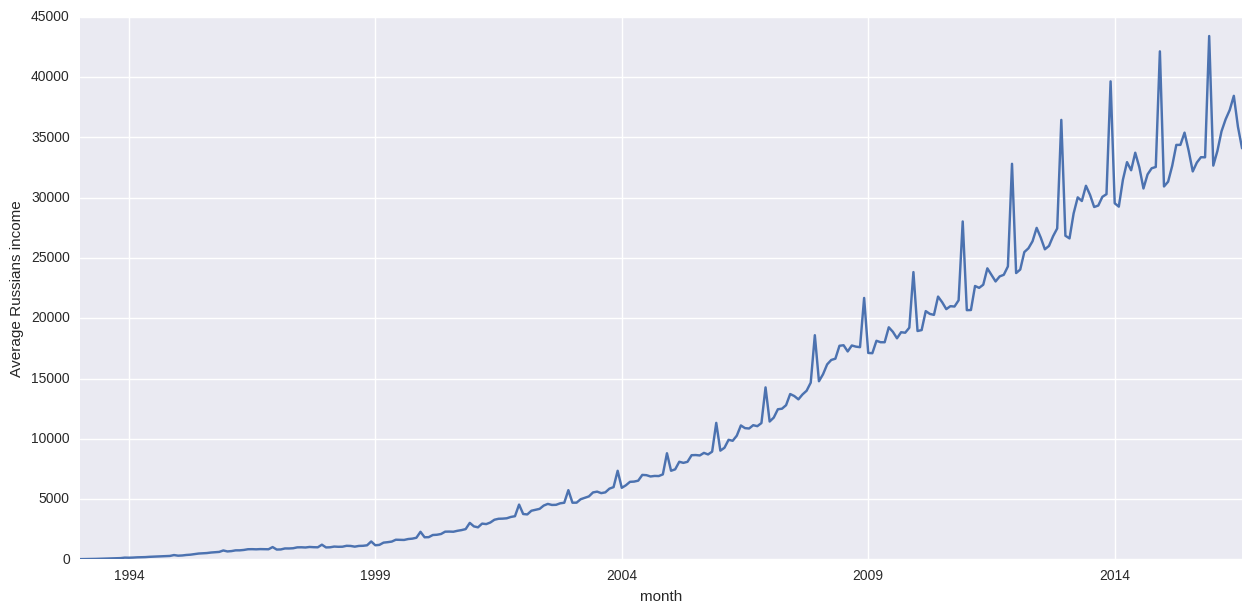

In [2]:
ru_salary = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
ru_salary.WAG_C_M.plot()
plt.ylabel('Average Russians income')
pylab.show()

Видно тренд, видно сезонность

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


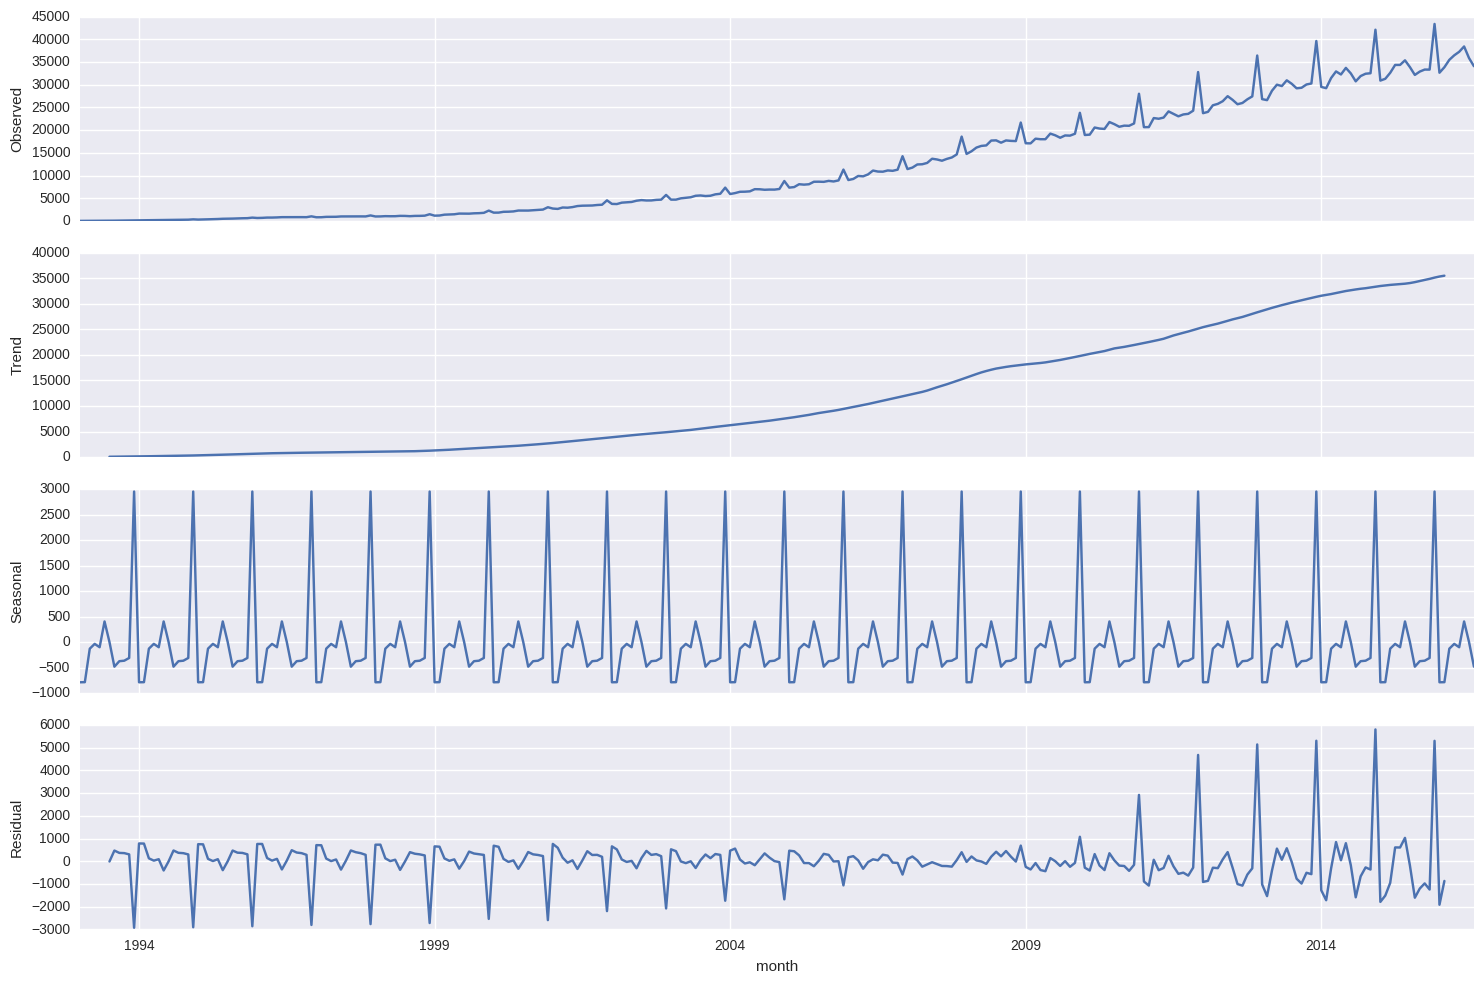

In [3]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(ru_salary.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ru_salary.WAG_C_M)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


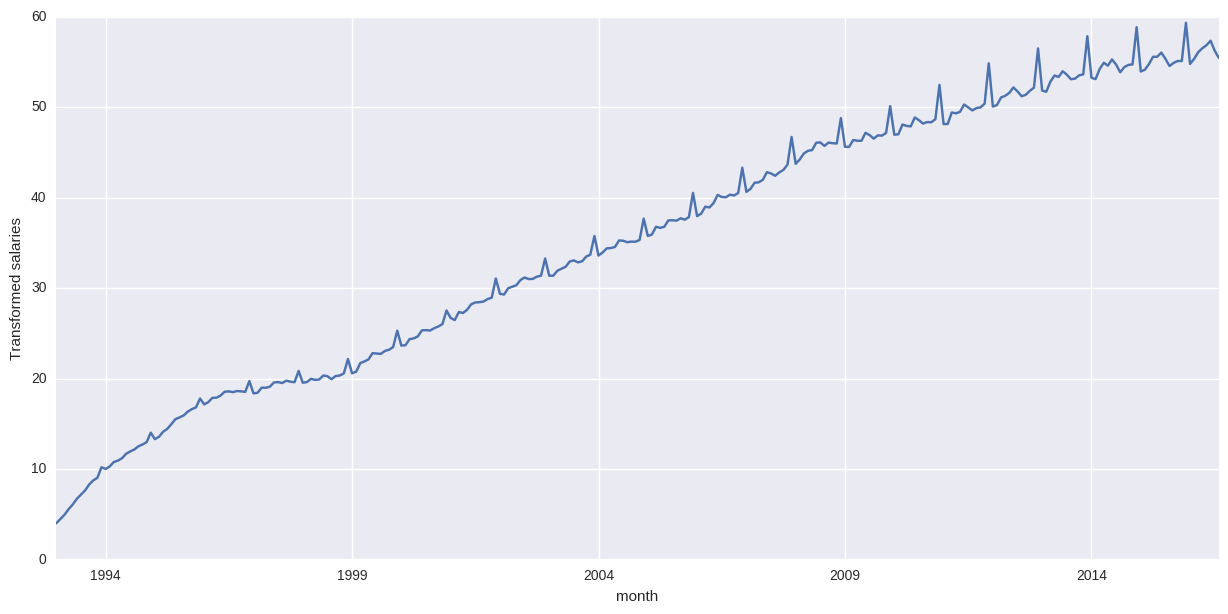

In [4]:
ru_salary['salaries_boxed'], lmbda = stats.boxcox(ru_salary.WAG_C_M)
plt.figure(figsize(15,7))
ru_salary.salaries_boxed.plot()
plt.ylabel(u'Transformed salaries')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ru_salary.salaries_boxed)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


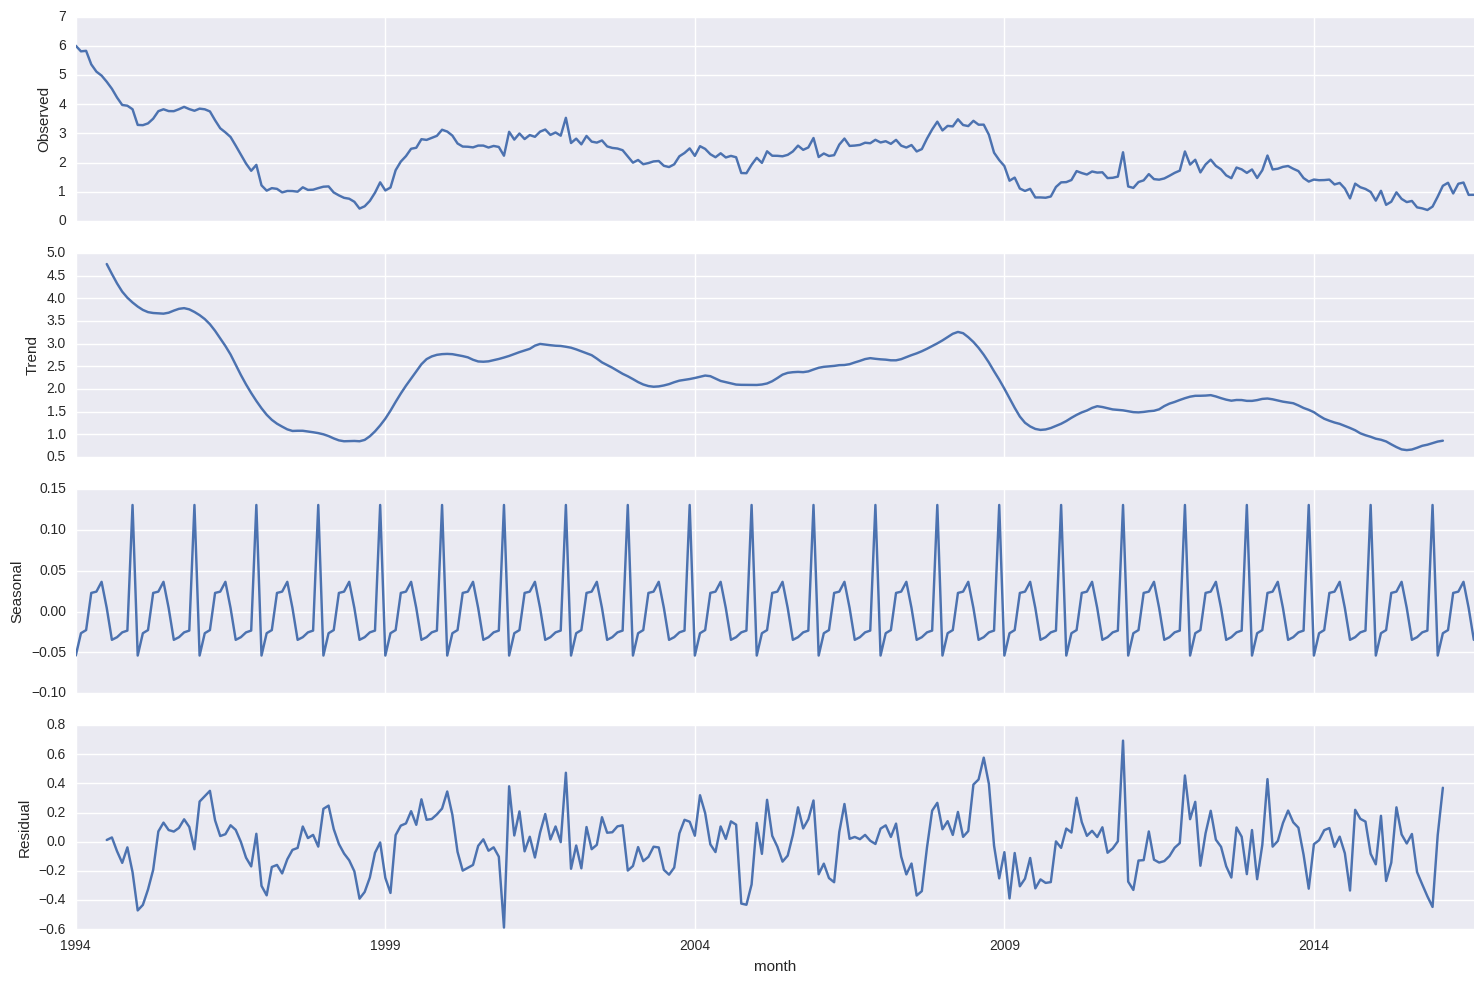

In [5]:
ru_salary['salaries_boxed_seasonal_1_diff'] = ru_salary.salaries_boxed - ru_salary.salaries_boxed.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(ru_salary.salaries_boxed_seasonal_1_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ru_salary.salaries_boxed_seasonal_1_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но в "тренде" будто бы еще осталась какая-то информация. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


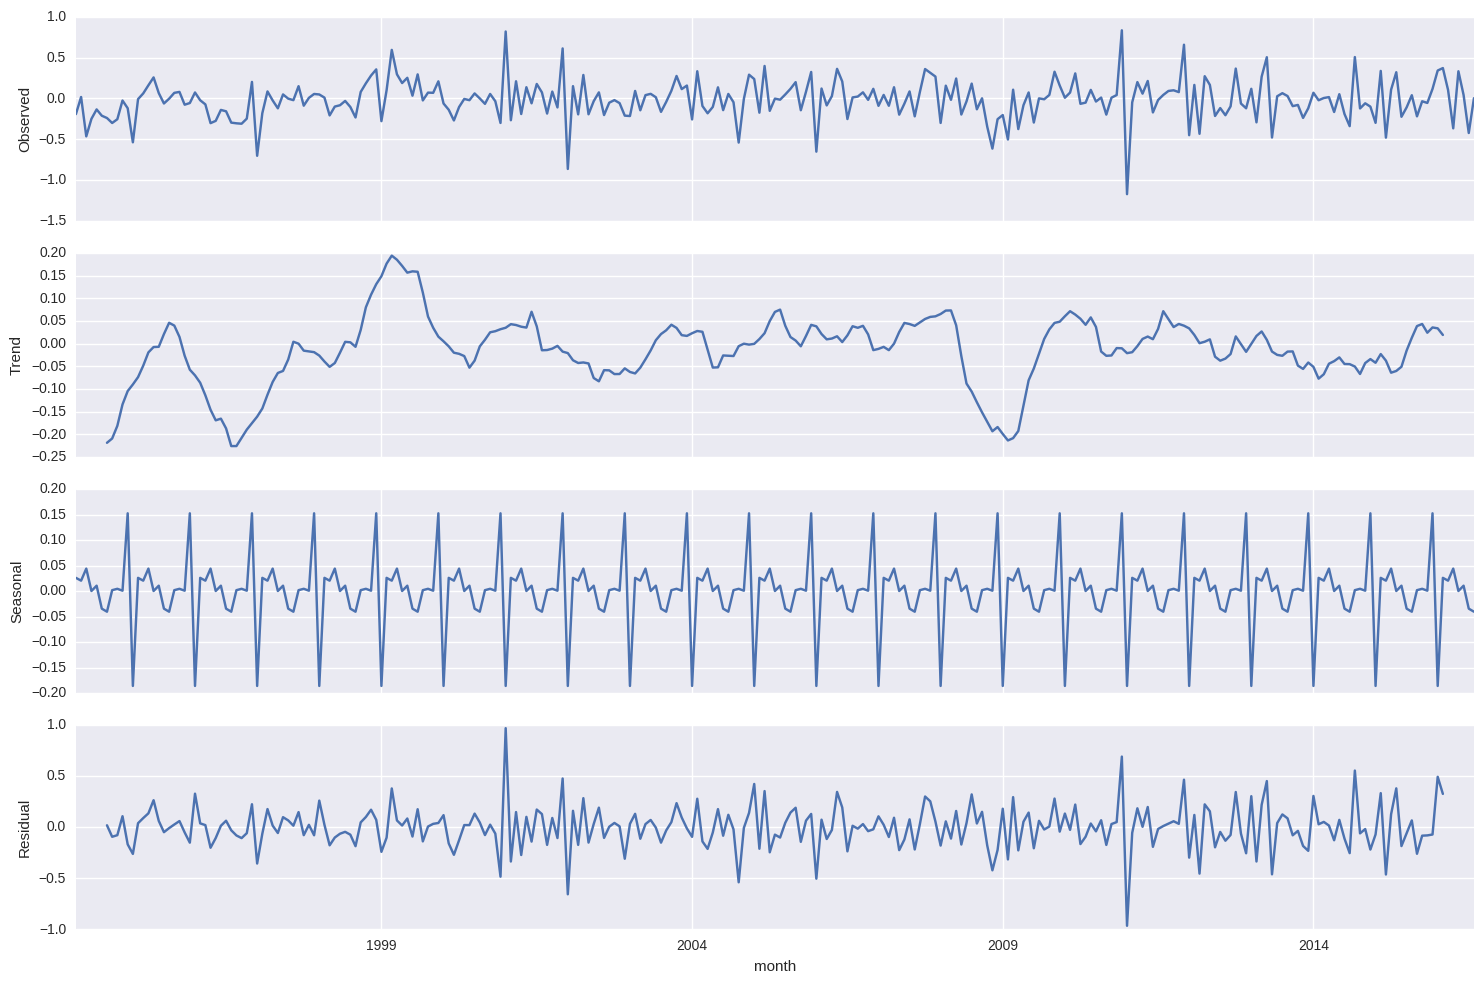

In [6]:
ru_salary['salaries_boxed_simple_1_diff_on_seasonal_1_diff'] = ru_salary.salaries_boxed_seasonal_1_diff - ru_salary.salaries_boxed_seasonal_1_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(ru_salary.salaries_boxed_simple_1_diff_on_seasonal_1_diff[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ru_salary.salaries_boxed_simple_1_diff_on_seasonal_1_diff[13:])[1])

Гипотеза нестационарности отвергается совсем сильно, от тренда остались только отдельные выбросы, но выбросы в остатках увеличились. Попробуем так, посмотрим, как пойдёт. 
UPDATE проверил, там AIC больше получается.

`ru_salary.salaries_boxed_simple_1_diff_on_seasonal_1_diff` -- крутое имя, но больно длинное

In [7]:
ru_salary['salaries_series'] = ru_salary.salaries_boxed_simple_1_diff_on_seasonal_1_diff

В исходной нотебуке Евгений держал в голове, сколько записей ему надо пропустить, чтобы не получить NaN, я лучше просто дропну эти записи.

In [8]:
ru_salary.dropna(inplace=True)

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

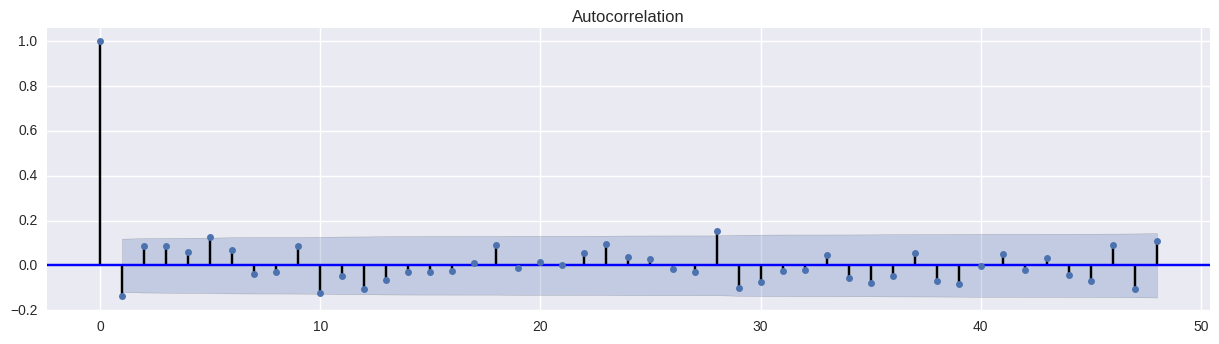

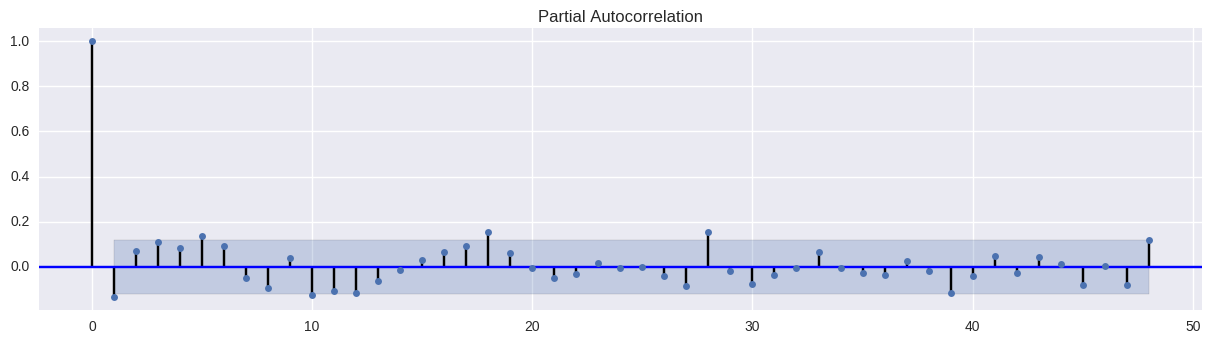

In [9]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(ru_salary.salaries_series.values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(ru_salary.salaries_series.values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=1, P=1, p=1. Как-то всё по краю.

In [10]:
ps = range(0, 3)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [12]:
# %%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(ru_salary.salaries_boxed, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 0, 1))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 1, 1))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 0, 1))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 1, 1))


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.
Например, обновить можно вот так: `!pip install -U statsmodels==0.8.0rc1`

In [13]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
12  (1, 0, 0, 1) -4.072719
13  (1, 0, 1, 0) -3.974402
4   (0, 1, 0, 1) -3.214426
5   (0, 1, 1, 0) -3.100665
8   (0, 2, 0, 1) -2.963775


Лучшая модель:

In [14]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     salaries_boxed   No. Observations:                  271
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood                   5.036
Date:                            Thu, 05 Jan 2017   AIC                             -4.073
Time:                                    14:56:44   BIC                              6.734
Sample:                                02-01-1994   HQIC                             0.266
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1826      0.046     -3.988      0.000      -0.272      -0.093
ma.S.L12      -0.1248      0.047   

Её остатки:

Критерий Стьюдента: p=0.670440
Критерий Дики-Фуллера: p=0.000000


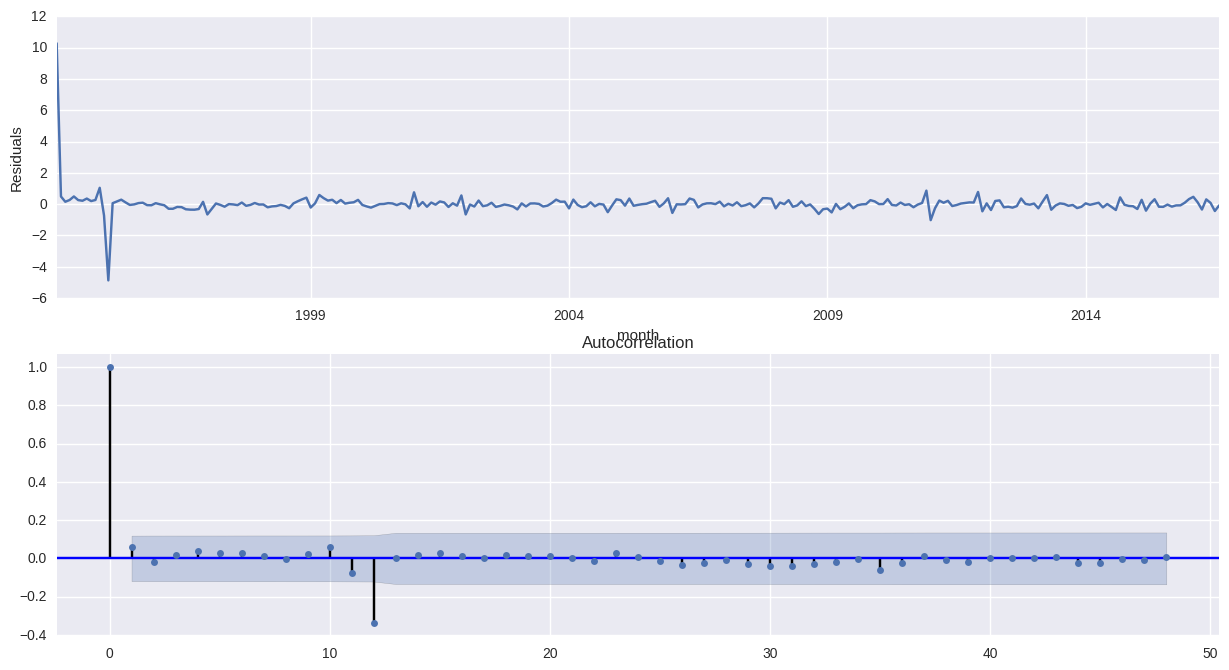

In [15]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

In [16]:
best_model.fittedvalues.shape

(271,)

In [17]:
ru_salary.salaries_series.shape

(271,)

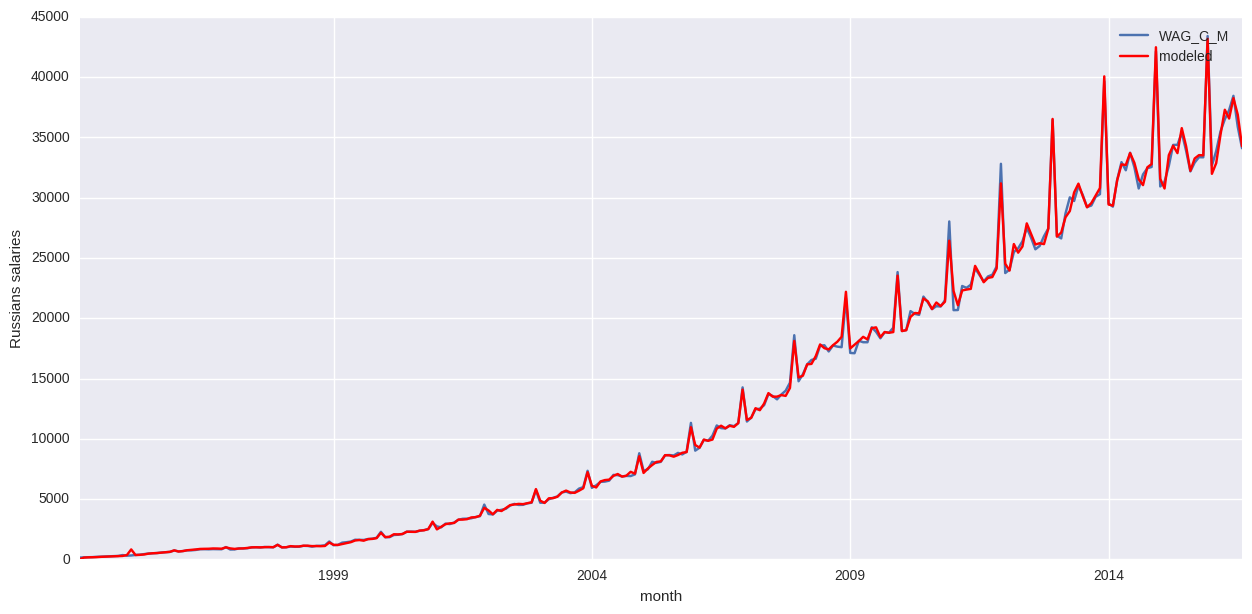

In [18]:
ru_salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
ru_salary.WAG_C_M.plot()
ru_salary.model.plot(color='r', label='modeled')
plt.ylabel('Russians salaries')
pylab.legend()
pylab.show()

### Прогноз

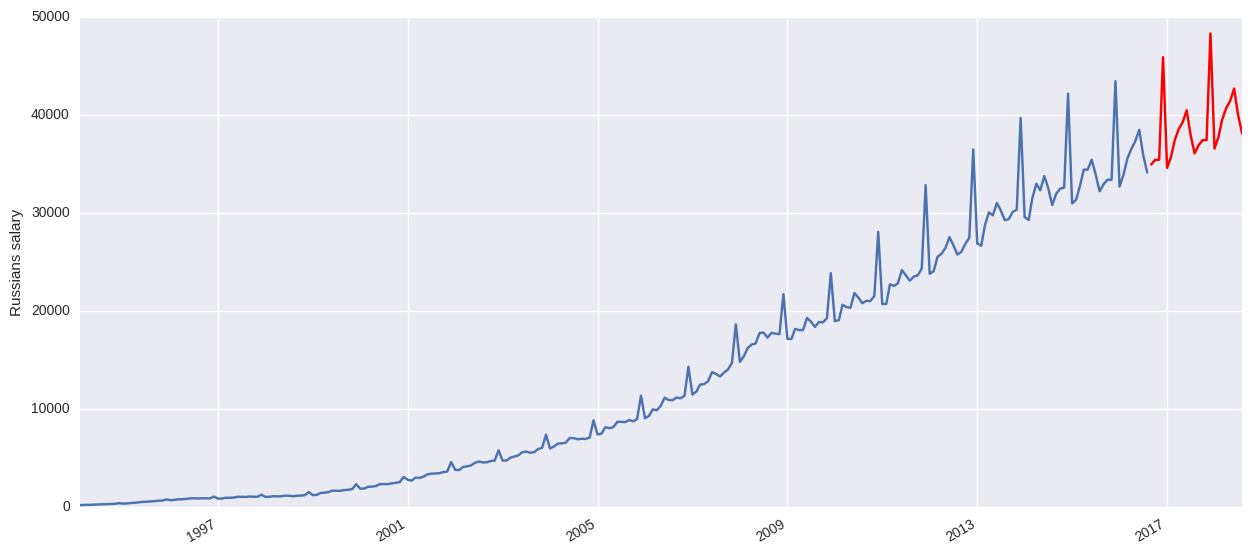

In [19]:
ru_salary2 = ru_salary[['WAG_C_M']]
date_list = [ru_salary.index[-1] + relativedelta(months=x) for x in range(0,12*2+1)]
future = pd.DataFrame(index=date_list, columns=ru_salary2.columns)
ru_salary2 = pd.concat([ru_salary2, future])
ru_salary2['forecast'] = invboxcox(best_model.predict(start=ru_salary.shape[0], end=ru_salary2.shape[0]), lmbda)

plt.figure(figsize(15,7))
ru_salary2.WAG_C_M.plot()
ru_salary2.forecast.plot(color='r')
plt.ylabel('Russians salary')
pylab.show()